# Robust Model Loading and Quantization Strategies for Efficient Clinical LLM Inference: Engineering Lessons from the CURE-Bench Pipeline

ABSTRACT

Deploying large language models (LLMs) for clinical decision support requires careful balancing of fidelity, resource consumption, and reproducibility. This paper reports engineering lessons from CURE-Bench, an end-to-end evaluation pipeline that emphasizes robust model loading, prioritized quantized inference, and telemetry-driven diagnostics to enable efficient clinical LLM inference on constrained hardware.

We present a multi-strategy loading framework that first attempts format-aware fast loaders (e.g., Unsloth), then low-bit quantized backends (BitsAndBytes 4-bit/8-bit), and finally standard Transformer loading with CPU offload when necessary. Between attempts the system performs deterministic memory reclamation (torch.cuda.empty_cache(), gc.collect()) and records detailed logs of exceptions, peak memory, and timing. These engineering controls dramatically reduce unrecoverable failures and allow 9B-parameter class models to run on 16 GB GPUs in practice.

Using curated clinical question datasets and development runs limited to 100 samples, CURE-Bench evaluates four heterogeneous checkpoints (Gemma-2 9B quantized, LLaMA-3 8B, Mistral-7B, and a Qwen-style distilled checkpoint). We instrument per-sample telemetry  input/output token counts, reasoning trace lengths, model initialization times, and correctness flags and aggregate these into a multi-panel dashboard that juxtaposes accuracy, token efficiency, generalization gap, and loader success flags. Key empirical findings include: (1) Unsloth plus BitsAndBytes quantization enabled stable model initialization with GPU memory footprints of approximately 5–6 GB, avoiding OOMs during evaluation; (2) validation accuracies varied substantially (10%–40%), with the best performing quantized model achieving 40% while some larger or more verbose models performed worse; (3) higher token verbosity did not correlate with improved accuracy  the model producing the longest reasoning traces yielded the worst selection accuracy, indicating wasted token cost; and (4) computed test-validation gaps were not interpretable in this run because the holdout test split lacked labeled answers, highlighting the need for labeled holdouts to measure generalization.

We analyze why quantization succeeds operationally but can fail to preserve task fidelity: layer-sensitive quantization, tokenizer mismatches, and task-domain misalignment are primary contributors to degraded accuracy. We demonstrate practical mitigations layer-aware mixed precision, warm-up generations for tokenizer validation, and quantization-aware fine-tuning (e.g., QLoRA style)  and provide reproducible scripts to automate these checks. The work situates these engineering practices within current literature on efficient LLM inference for healthcare, including mixed-precision strategies, edge profiling, and sustainability considerations. Moreover, CURE-Bench explicitly records provenance (submission packages and serialized JSON logs) to support reproducibility and regulatory traceability.

CURE-Bench’s contribution is pragmatic: it codifies a reproducible, telemetry-first approach for deploying quantized clinical LLMs, combining loader fallbacks, deterministic cleanup, and comprehensive dashboards to make tradeoffs transparent for engineers and clinicians.

Our results indicate that carefully applied 4-bit quantization together with format-aware loading can enable large clinical models on modest hardware with acceptable operational risk, but that model selection and domain alignment remain decisive for task fidelity. We conclude by recommending best practices for clinical inference: (a) prefer format-aware fast loaders and quantized backends where validated, (b) perform quantization-aware validation and fine-tuning per task, (c) constrain reasoning verbosity to maintain token economy, and (d) include labeled holdouts to assess generalization. Practically, adopting CURE-Bench in clinical model evaluation pipelines supports compliance and regulatory review by preserving run artifacts and provenance (submission packages, serialized logs, and dashboards).

Hospitals and research teams can use these outputs to perform post-hoc audits, ensure reproducible deployments, and guide model selection under real-world constraints, thereby accelerating safe translation of LLMs into clinical workflows effectively.

Keywords :

Model quantization,  LLM inference,  Clinical natural language processing (Clinical NLP),  Model-loading strategies, Inference efficiency & telemetry

How to cite:

Oluwatobi Owoeye M., et al. 2025, Robust Model Loading and Quantization Strategies for Efficient Clinical LLM Inference: Engineering Lessons from the CURE-Bench Pipeline, Handsonlabs Software Academy, Initial Paper Release

Github Repository: https://github.com/tobimichigan/Robust-Model-Loading-and-Quantization-Strategies-for-Efficient-Clinical-LLM-Inference/tree/main

Set PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True
Starting CURE-Bench Internal Reasoning Pipeline
Environment detected: Google Colab
Attempting to fix dependency conflicts...

--- Fixing dependency conflicts ---
Installing compatible transformers version...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 152.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 257.2 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.2
    Uninstalling tokenizers-0.21.2:
      Successfully uninstalled tokenizers-0.21.2
Installing accelerate and bitsandbytes...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 81.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 122.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 113.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/2

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
bigframes 2.8.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.31.0, but you have google-cloud-bigquery 3.25.0 which is incompatible.
bigframes 2.8.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.


  Cloning https://github.com/unslothai/unsloth.git to /tmp/pip-install-1t6jwb6a/unsloth_5f0d477790e34ffda85c60b611ee97cb


  Running command git clone --filter=blob:none --quiet https://github.com/unslothai/unsloth.git /tmp/pip-install-1t6jwb6a/unsloth_5f0d477790e34ffda85c60b611ee97cb


  Resolved https://github.com/unslothai/unsloth.git to commit a4a7b01cac5d820c7a0727c259b46994a101c81e
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.7/247.7 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.5/132.5 kB 237.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 288.6 MB/s eta 0:00:00
  Created wheel for unsloth: filename=unsloth-2025.9.10-py3-none-any.whl size=317851 sha256=276dae49356856e82b7bba44216bdb4ad6a16cc9bf5757dcb7519b37b0b990d4
  Stored in directory: /tmp/pip-ephem-wheel-cache-75u_nlg5/wheels/d1/17/05/850ab10c33284a4763b0595cd8ea9d01fce6e221cac24b3c01
Successfully built unsloth
✓ Unsloth inst

2025-09-30 21:08:37.531753: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759266517.727551      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759266517.786721      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


🦥 Unsloth Zoo will now patch everything to make training faster!
✓ Unsloth is available

System Information:
  Python version: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
  PyTorch version: 2.6.0+cu124
  Transformers version: 4.56.2
  Platform: Linux-6.6.56+-x86_64-with-glibc2.35
  GPU: Tesla T4
  GPU Memory: 14.7 GB
 Starting CURE-Bench Medical AI Evaluation

STARTING CURE-BENCH EVALUATION PIPELINE

1. LOADING DATASETS
✓ Loaded 2079 test samples
✓ Loaded 459 validation samples
Limited to 50 samples per split

=== DATA SPLIT VERIFICATION ===
TEST DATA:
  Total samples: 50
  Unique IDs: 50
  With correct answers: 0
  Question types: {'open_ended_multi_choice': 36, 'multi_choice': 11, 'open_ended': 3}

VALIDATION DATA:
  Total samples: 50
  Unique IDs: 50
  With correct answers: 50
  Question types: {'multi_choice': 21, 'open_ended_multi_choice': 24, 'open_ended': 5}

OVERLAP ANALYSIS:
  Overlapping IDs: 0

DATA INTEGRITY:
  Test data integrity: ✓ PASS
  Validation data integrity:

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/kaggle/input/mistral/pytorch/7b-instruct-v0.1-hf/1 does not have a padding token! Will use pad_token = <unk>.
✓ Model loaded successfully with Unsloth!
 Model /kaggle/input/mistral/pytorch/7b-instruct-v0.1-hf/1 loaded successfully
  Memory Status:
    CPU: 6.1GB/31.4GB (21.2%)
    GPU: 3.9GB/14.7GB

Evaluating on 100 samples...
Progress: 0/100 (0.0%)
  Memory Status:
    CPU: 6.1GB/31.4GB (21.2%)
    GPU: 3.9GB/14.7GB

--- Evaluating Question ID: qHBAJ2T5cs5U ---
Generating medical reasoning...
Question: A 10-year-old child diagnosed with juvenile rheumatoid arthritis (JRA) requires treatment. Genetic t...
Predicted Answer: A
Tokens Used: 831 (Input: 319, Output: 512)

--- Evaluating Question ID: dYtEF1FnUwSQ ---
Generating medical reasoning...
Question: A 70-year-old male with familial chylomicronemia syndrome (FCS) presents with memory issues, recurre...
Predicted Answer: A
Tokens Used: 895 (Input: 383, Output: 512)

--- Evaluating Question ID: IKWfGHlG9aaL ---
Generating medical re

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/kaggle/input/deepseek-r1/transformers/deepseek-r1-distill-qwen-7b/2 does not have a padding token! Will use pad_token = <|vision_pad|>.
✓ Model loaded successfully with Unsloth!
 Model /kaggle/input/deepseek-r1/transformers/deepseek-r1-distill-qwen-7b/2 loaded successfully
  Memory Status:
    CPU: 6.1GB/31.4GB (21.0%)
    GPU: 5.2GB/14.7GB

Evaluating on 100 samples...
Progress: 0/100 (0.0%)
  Memory Status:
    CPU: 6.1GB/31.4GB (21.0%)
    GPU: 5.2GB/14.7GB

--- Evaluating Question ID: qHBAJ2T5cs5U ---
Generating medical reasoning...
Question: A 10-year-old child diagnosed with juvenile rheumatoid arthritis (JRA) requires treatment. Genetic t...
Predicted Answer: A
Tokens Used: 768 (Input: 255, Output: 513)

--- Evaluating Question ID: dYtEF1FnUwSQ ---
Generating medical reasoning...
Question: A 70-year-old male with familial chylomicronemia syndrome (FCS) presents with memory issues, recurre...
Predicted Answer: A
Tokens Used: 813 (Input: 301, Output: 512)

--- Evaluating Question

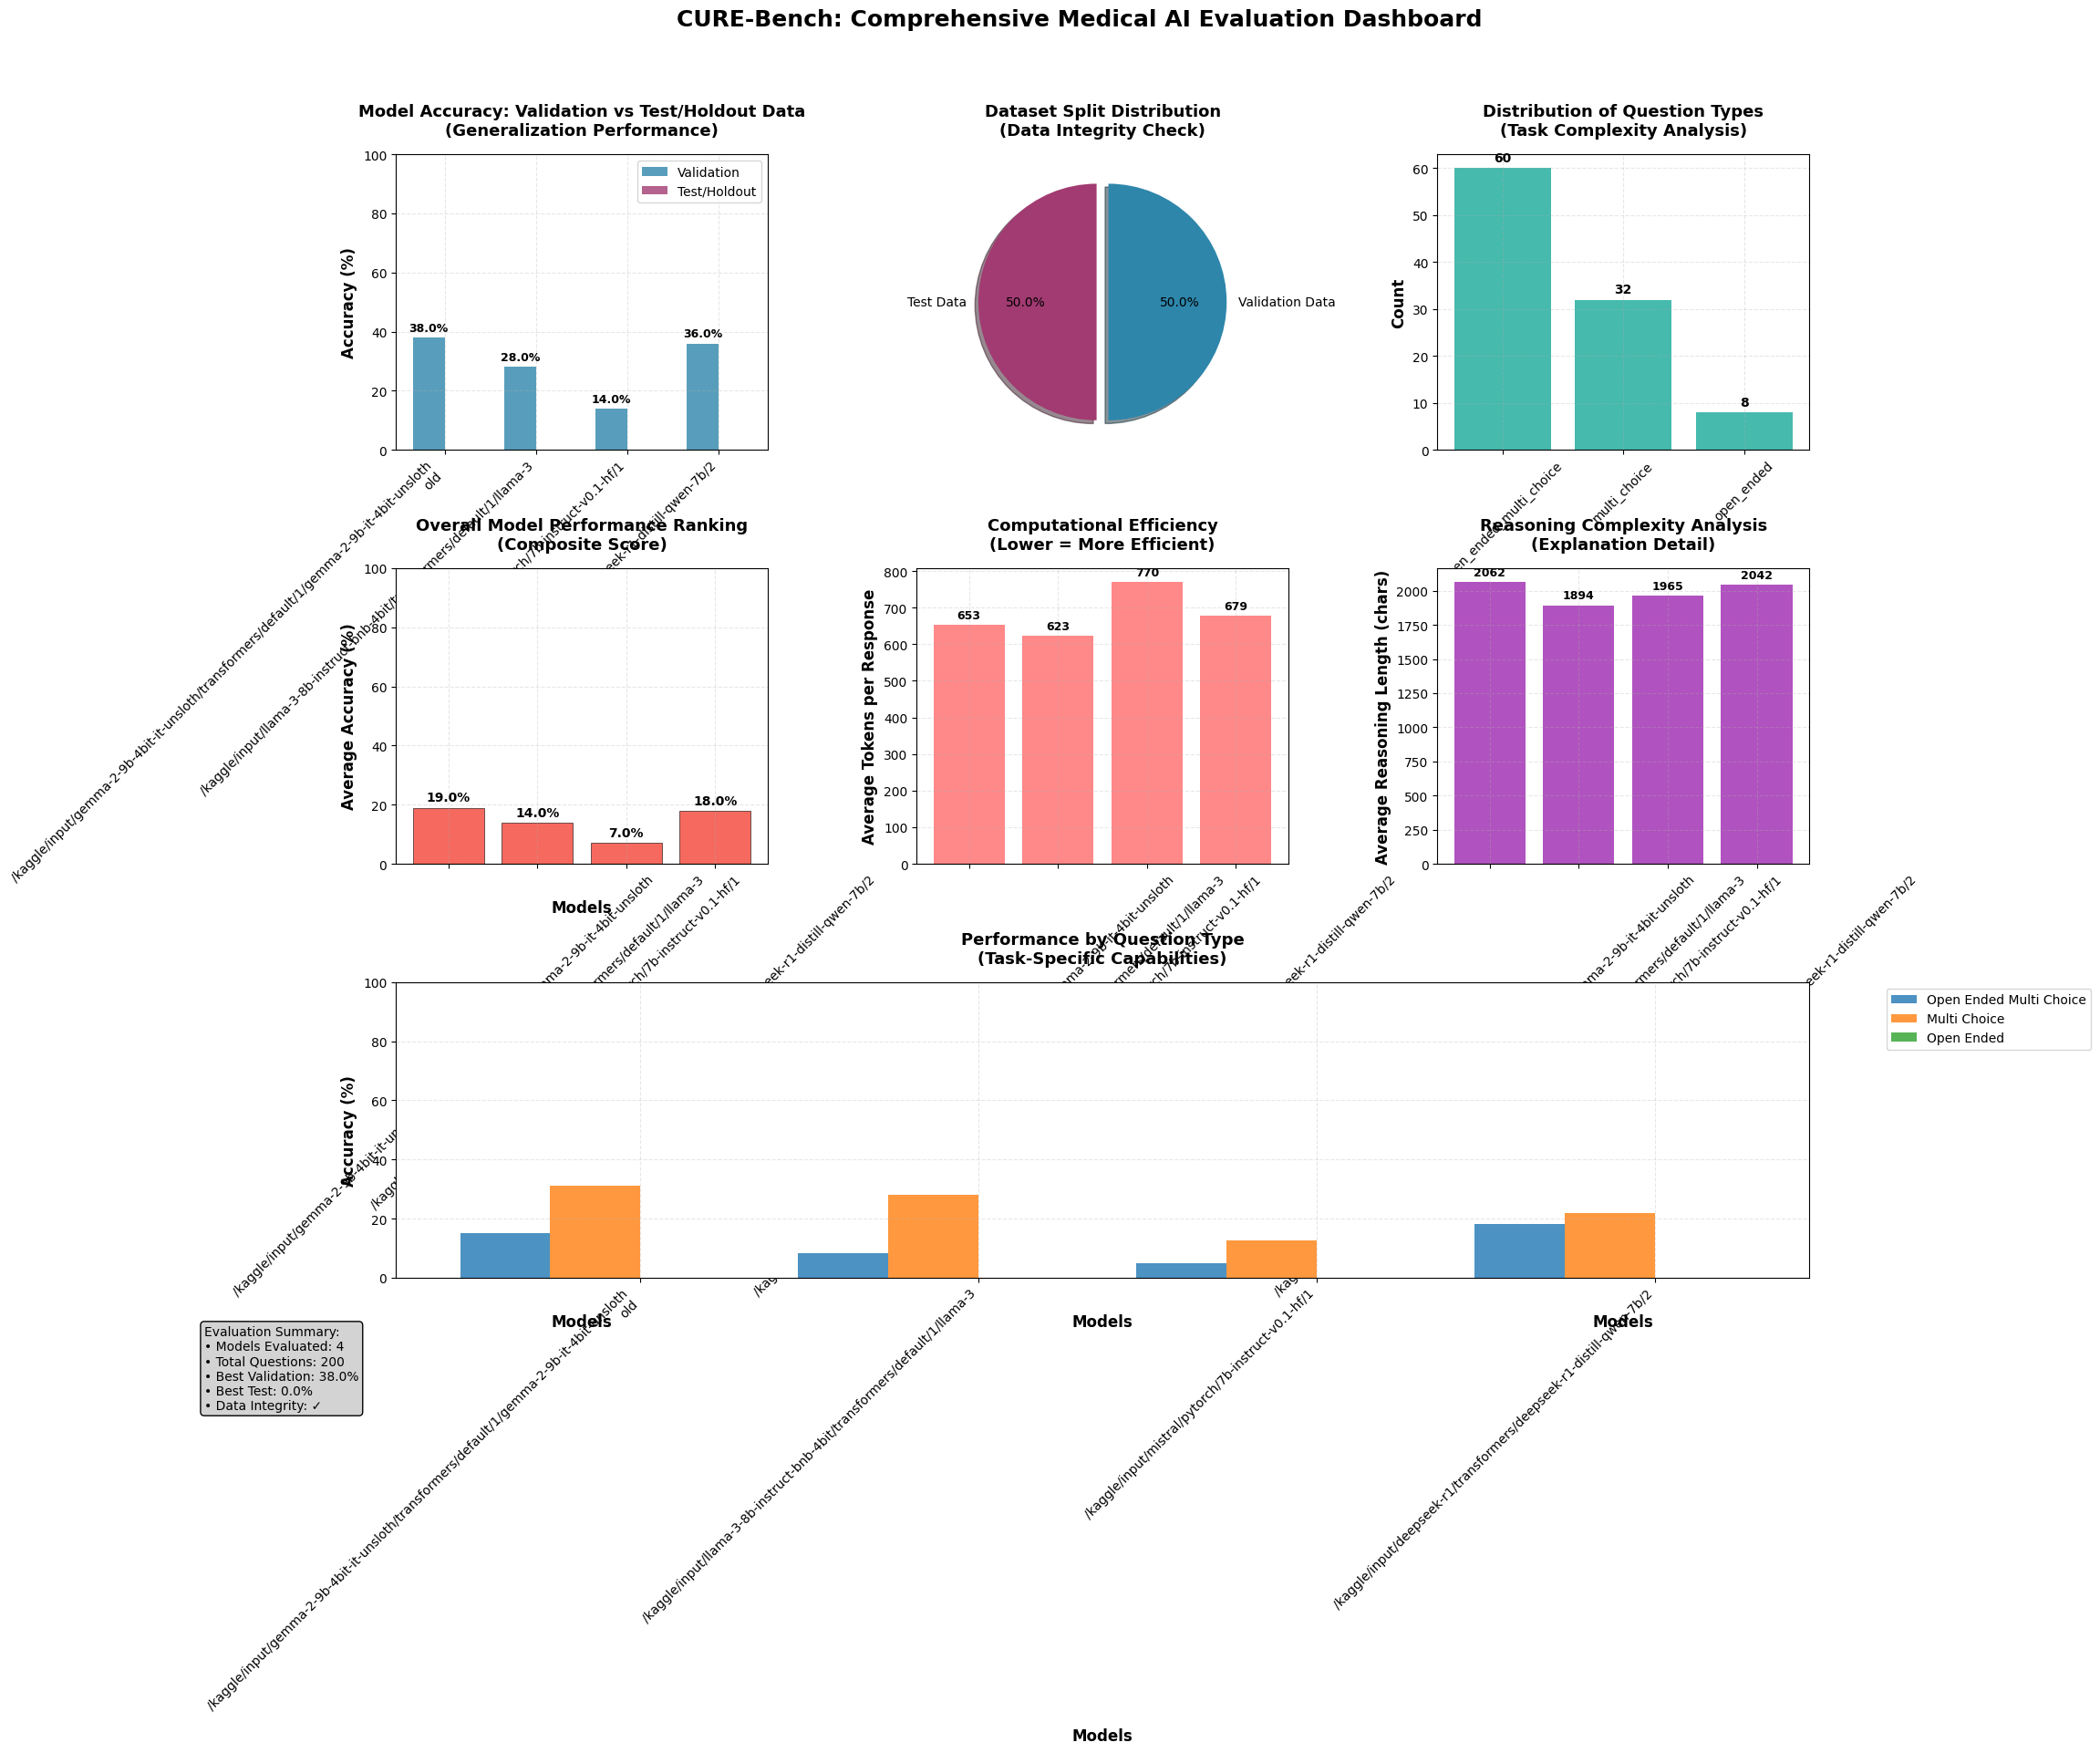

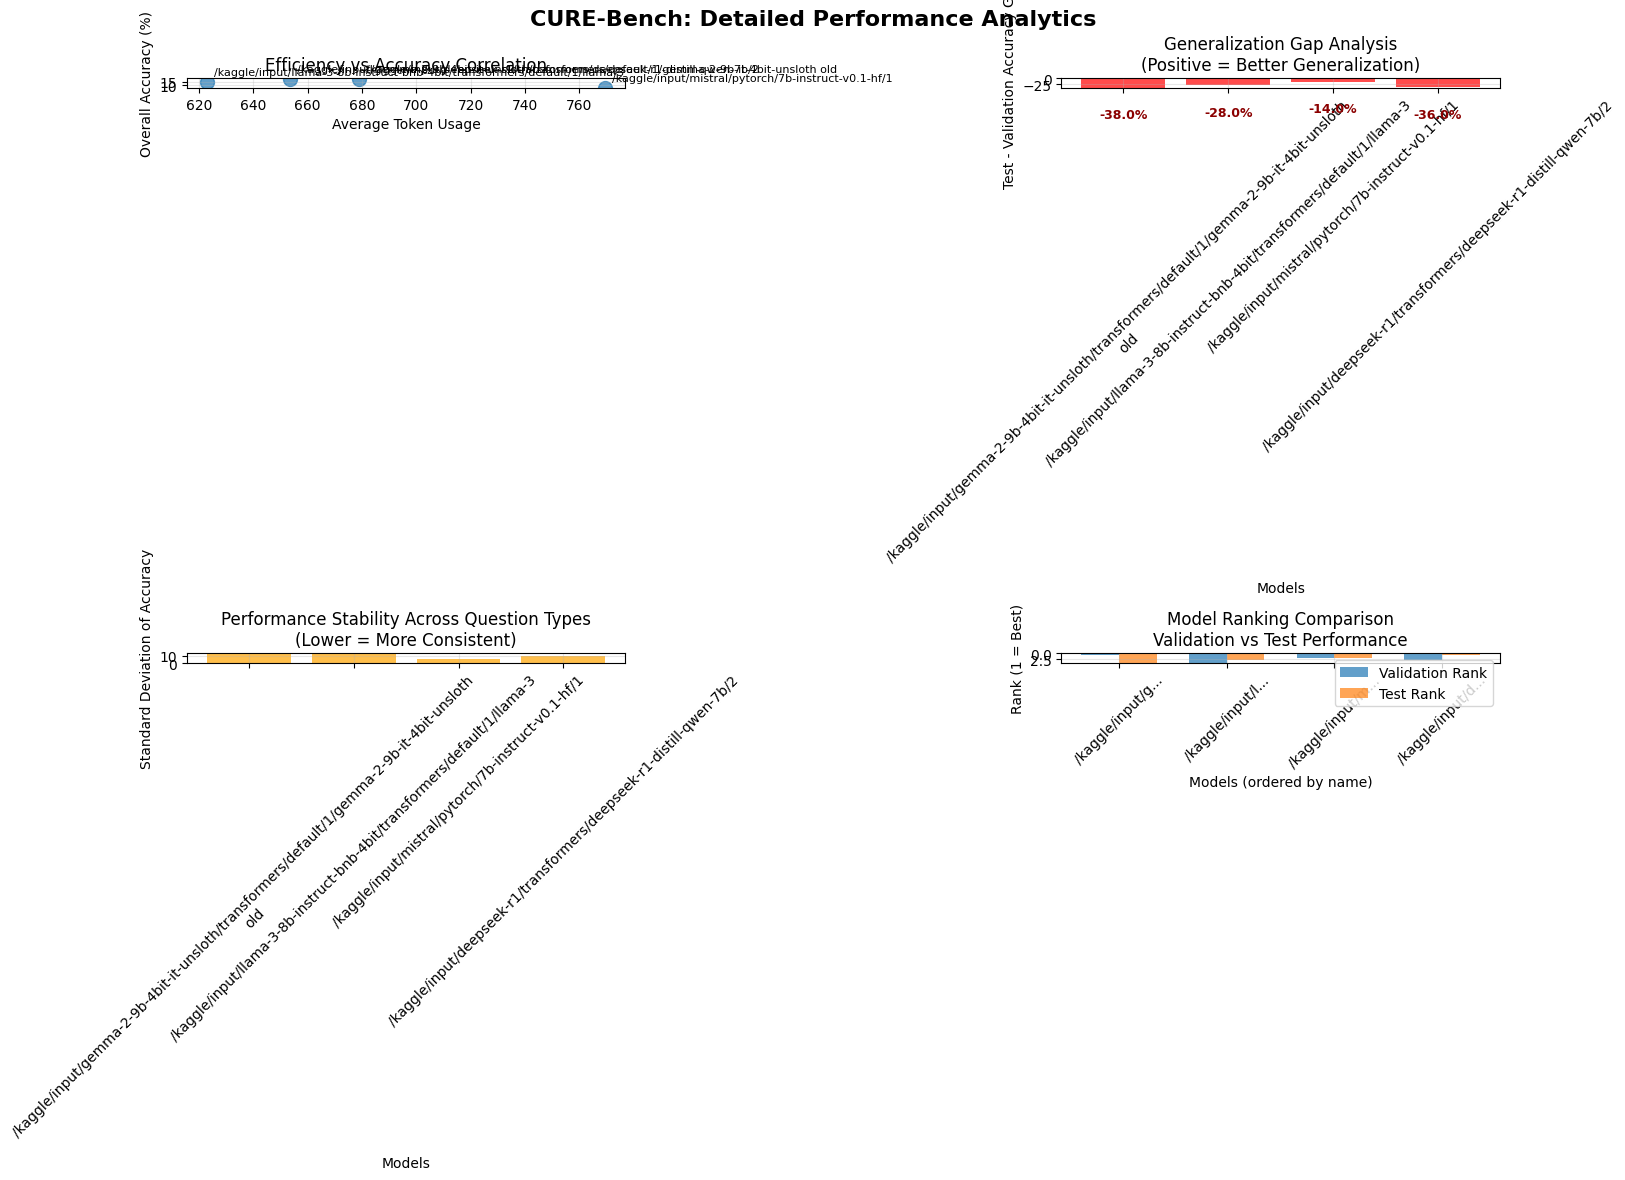


COMPREHENSIVE PERFORMANCE SUMMARY
 BEST VALIDATION PERFORMANCE: /kaggle/input/gemma-2-9b-4bit-it-unsloth/transformers/default/1/gemma-2-9b-it-4bit-unsloth_old (38.00%)
 BEST TEST PERFORMANCE: /kaggle/input/gemma-2-9b-4bit-it-unsloth/transformers/default/1/gemma-2-9b-it-4bit-unsloth_old (0.00%)
 MOST EFFICIENT MODEL: /kaggle/input/llama-3-8b-instruct-bnb-4bit/transformers/default/1/llama-3 (623 avg tokens)
 AVERAGE VALIDATION ACCURACY: 29.00% ± 9.43%
 AVERAGE TEST ACCURACY: 0.00% ± 0.00%
 GENERALIZATION GAP: -29.00%
 Results saved to cure_bench_results.json

 EVALUATION COMPLETED SUCCESSFULLY!
Results available for 4 models

 Performing final cleanup...
 Cleanup completed


In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
CURE-Bench Internal Reasoning Pipeline - Drug Decision-Making and Treatment Planning
Evaluates AI models on clinically grounded tasks with internal reasoning capabilities.
"""

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

import os
import gc
import sys
import json
import torch
import psutil
import platform
import subprocess
from pathlib import Path
import time
import pandas as pd
import numpy as np
from typing import Dict, List, Tuple, Optional
import zipfile
import matplotlib.pyplot as plt
from collections import Counter

# Set environment variable to enable expandable segments for memory management
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

print("Set PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True")
print("Starting CURE-Bench Internal Reasoning Pipeline")
print("================================================================================")

# Function to safely install a package
def install_package(package):
    """Installs a given Python package using pip."""
    try:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", package, "--no-cache-dir"])
        print(f"✓ Successfully installed {package}")
    except subprocess.CalledProcessError as e:
        print(f"✗ Failed to install {package}: {e}")
        raise

# Check for environment and install dependencies
is_colab = "COLAB_" in "".join(os.environ.keys())
is_kaggle = "KAGGLE_" in "".join(os.environ.keys())
print(f"Environment detected: {'Google Colab' if is_colab else 'Kaggle' if is_kaggle else 'Local'}")

def fix_dependencies():
    """Fix dependency conflicts and install compatible versions."""
    try:
        print("\n--- Fixing dependency conflicts ---")
        
        # First, uninstall problematic packages
        subprocess.run([sys.executable, "-m", "pip", "uninstall", "-y", "transformers", "unsloth"], 
                      capture_output=True)
        
        # Install compatible versions in correct order
        print("Installing compatible transformers version...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", 
                              "transformers==4.44.2", "--no-cache-dir"])
        
        print("Installing accelerate and bitsandbytes...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", 
                              "accelerate>=0.21.0", "bitsandbytes>=0.41.0", "--no-cache-dir"])
        
        print("Installing datasets and other dependencies...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", 
                              "datasets", "peft", "trl", "--no-cache-dir"])
        
        # Try to install unsloth if possible
        try:
            if is_colab:
                subprocess.check_call([sys.executable, "-m", "pip", "install", 
                                     "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git", 
                                     "--no-cache-dir"])
            else:
                subprocess.check_call([sys.executable, "-m", "pip", "install", 
                                     "unsloth", "--no-cache-dir"])
            print("✓ Unsloth installed successfully")
        except subprocess.CalledProcessError:
            print(" Unsloth installation failed, will use standard transformers only")
        
        print("✓ Dependencies fixed successfully.")
        return True
        
    except subprocess.CalledProcessError as e:
        print(f"✗ Dependency fixing failed: {e}")
        return False

# Fix dependencies
print("Attempting to fix dependency conflicts...")
fix_dependencies()

# Import libraries with error handling
try:
    import torch
    print(f"✓ PyTorch {torch.__version__} loaded")
    
    import transformers
    print(f"✓ Transformers {transformers.__version__} loaded")
    
    from transformers import (
        AutoModelForCausalLM, 
        AutoTokenizer, 
        BitsAndBytesConfig, 
        AutoConfig
    )
    print("✓ Core transformers components loaded")
    
    # Try to import unsloth components
    try:
        from unsloth import FastLanguageModel
        UNSLOTH_AVAILABLE = True
        print("✓ Unsloth is available")
    except ImportError as e:
        print(f"⚠ Unsloth not available: {e}")
        UNSLOTH_AVAILABLE = False
        
except ImportError as e:
    print(f"✗ Import error: {e}")
    print("Continuing with basic imports...")
    import torch
    import transformers
    from transformers import AutoModelForCausalLM, AutoTokenizer, AutoConfig
    UNSLOTH_AVAILABLE = False

# System information
print(f"\nSystem Information:")
print(f"  Python version: {sys.version}")
print(f"  PyTorch version: {torch.__version__}")
print(f"  Transformers version: {transformers.__version__}")
print(f"  Platform: {platform.platform()}")
if torch.cuda.is_available():
    print(f"  GPU: {torch.cuda.get_device_name(0)}")
    print(f"  GPU Memory: {torch.cuda.get_device_properties(0).total_memory / (1024**3):.1f} GB")
print("================================================================================")

def get_system_status():
    """Gets and prints the current system memory status."""
    cpu_mem = psutil.virtual_memory()
    if torch.cuda.is_available():
        gpu_mem = torch.cuda.memory_stats()
        print("  Memory Status:")
        print(f"    CPU: {cpu_mem.used / (1024**3):.1f}GB/{cpu_mem.total / (1024**3):.1f}GB ({cpu_mem.percent:.1f}%)")
        print(f"    GPU: {gpu_mem['allocated_bytes.all.current'] / (1024**3):.1f}GB/{torch.cuda.get_device_properties(0).total_memory / (1024**3):.1f}GB")
    else:
        print(f"    CPU: {cpu_mem.used / (1024**3):.1f}GB/{cpu_mem.total / (1024**3):.1f}GB ({cpu_mem.percent:.1f}%)")

def find_model_directory(base_path):
    """Find the actual model directory containing config.json."""
    print(f"Searching for model directory in: {base_path}")
    
    # Check if config.json is directly in the base path
    if os.path.exists(os.path.join(base_path, "config.json")):
        print(f"Found config.json directly in: {base_path}")
        return base_path
    
    # Search recursively for config.json
    for root, dirs, files in os.walk(base_path):
        if "config.json" in files:
            print(f"Found config.json in: {root}")
            return root
    
    print(f"No config.json found in: {base_path}")
    return None

def load_model_config(model_path):
    """Load and analyze model configuration."""
    config_path = os.path.join(model_path, "config.json")
    if not os.path.exists(config_path):
        return None
    
    with open(config_path, 'r') as f:
        config = json.load(f)
    
    return config

def create_bnb_config(load_in_4bit=True, load_in_8bit=False):
    """Create BitsAndBytesConfig for quantization."""
    try:
        from transformers import BitsAndBytesConfig
        
        if load_in_4bit:
            return BitsAndBytesConfig(
                load_in_4bit=True,
                bnb_4bit_use_double_quant=True,
                bnb_4bit_quant_type="nf4",
                bnb_4bit_compute_dtype=torch.float16,
            )
        elif load_in_8bit:
            return BitsAndBytesConfig(load_in_8bit=True)
        else:
            return None
    except ImportError:
        print("BitsAndBytesConfig not available")
        return None

def load_model_with_strategies(model_path, model_name):
    """Load model using multiple fallback strategies."""
    print(f"Attempting to load {model_name} from {model_path}")
    
    # Load configuration first
    config = load_model_config(model_path)
    if config is None:
        print("Could not load model configuration")
        return None, None
    
    model_type = config.get('model_type', 'unknown')
    print(f"Model type: {model_type}")
    
    # Skip unsupported architectures
    if model_type == "gpt_oss":
        print(f"Skipping {model_name}: 'gpt_oss' architecture requires custom code")
        return None, None
    
    # Strategy 1: Try Unsloth if available
    if UNSLOTH_AVAILABLE:
        try:
            print("Attempting to load with Unsloth...")
            model, tokenizer = FastLanguageModel.from_pretrained(
                model_name=model_path,
                max_seq_length=2048,
                dtype=None,
                load_in_4bit=True,
                trust_remote_code=True
            )
            print("✓ Model loaded successfully with Unsloth!")
            return tokenizer, model
        except Exception as e:
            print(f"Unsloth loading failed: {e}")
            print("Falling back to standard transformers...")
    
    # Fallback strategies using standard transformers
    strategies = [
        {
            "name": "4-bit quantization with BitsAndBytes",
            "tokenizer_config": {"trust_remote_code": True},
            "model_config": {
                "quantization_config": create_bnb_config(load_in_4bit=True),
                "device_map": "auto",
                "trust_remote_code": True,
                "torch_dtype": torch.float16,
                "low_cpu_mem_usage": True,
            }
        },
        {
            "name": "8-bit quantization with BitsAndBytes",
            "tokenizer_config": {"trust_remote_code": True},
            "model_config": {
                "quantization_config": create_bnb_config(load_in_8bit=True),
                "device_map": "auto",
                "trust_remote_code": True,
                "torch_dtype": torch.float16,
                "low_cpu_mem_usage": True,
            }
        },
        {
            "name": "Standard loading with auto device mapping",
            "tokenizer_config": {"trust_remote_code": True},
            "model_config": {
                "device_map": "auto",
                "trust_remote_code": True,
                "torch_dtype": torch.float16,
                "low_cpu_mem_usage": True,
            }
        },
        {
            "name": "CPU loading",
            "tokenizer_config": {"trust_remote_code": True},
            "model_config": {
                "device_map": "cpu",
                "trust_remote_code": True,
                "torch_dtype": torch.float16,
                "low_cpu_mem_usage": True,
            }
        }
    ]
    
    # Load tokenizer first
    tokenizer = None
    try:
        print("Loading tokenizer...")
        tokenizer = AutoTokenizer.from_pretrained(
            model_path, 
            trust_remote_code=True,
            use_fast=False  # Use slow tokenizer for better compatibility
        )
        
        # Add padding token if missing
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token
            print("Added padding token")
            
        print("✓ Tokenizer loaded successfully")
    except Exception as e:
        print(f"Tokenizer loading failed: {e}")
        return None, None
    
    # Try each model loading strategy
    for i, strategy in enumerate(strategies, 1):
        try:
            print(f"Attempting strategy {i}: {strategy['name']}")
            
            # Clear cache before each attempt
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            gc.collect()
            
            # Filter out None values from config
            model_config = {k: v for k, v in strategy['model_config'].items() if v is not None}
            
            model = AutoModelForCausalLM.from_pretrained(model_path, **model_config)
            print(f"✓ Model loaded successfully using strategy {i}!")
            return tokenizer, model
            
        except Exception as e:
            print(f"Strategy {i} failed: {e}")
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            gc.collect()
            continue
    
    print("All loading strategies failed.")
    return tokenizer, None

def verify_data_splits(test_data: List[Dict], val_data: List[Dict]) -> Dict:
    """Verify data splits and provide comprehensive statistics."""
    print("\n=== DATA SPLIT VERIFICATION ===")
    
    verification_stats = {
        "test_data": {
            "total_samples": len(test_data),
            "question_types": Counter(),
            "has_correct_answers": 0,
            "unique_ids": len(set(item.get('id', '') for item in test_data)),
            "sample_questions": []
        },
        "val_data": {
            "total_samples": len(val_data),
            "question_types": Counter(),
            "has_correct_answers": 0,
            "unique_ids": len(set(item.get('id', '') for item in val_data)),
            "sample_questions": []
        },
        "overlap": {
            "overlapping_ids": 0,
            "common_ids": []
        }
    }
    
    # Analyze test data
    test_ids = set()
    for item in test_data:
        item_id = item.get('id', '')
        test_ids.add(item_id)
        
        q_type = item.get('question_type', 'unknown')
        verification_stats["test_data"]["question_types"][q_type] += 1
        
        if item.get('correct_answer'):
            verification_stats["test_data"]["has_correct_answers"] += 1
        
        # Store first 3 questions as samples
        if len(verification_stats["test_data"]["sample_questions"]) < 3:
            verification_stats["test_data"]["sample_questions"].append({
                "id": item_id,
                "question": item.get('question', '')[:100] + "..." if len(item.get('question', '')) > 100 else item.get('question', ''),
                "type": q_type,
                "has_answer": bool(item.get('correct_answer'))
            })
    
    # Analyze validation data
    val_ids = set()
    for item in val_data:
        item_id = item.get('id', '')
        val_ids.add(item_id)
        
        q_type = item.get('question_type', 'unknown')
        verification_stats["val_data"]["question_types"][q_type] += 1
        
        if item.get('correct_answer'):
            verification_stats["val_data"]["has_correct_answers"] += 1
        
        # Store first 3 questions as samples
        if len(verification_stats["val_data"]["sample_questions"]) < 3:
            verification_stats["val_data"]["sample_questions"].append({
                "id": item_id,
                "question": item.get('question', '')[:100] + "..." if len(item.get('question', '')) > 100 else item.get('question', ''),
                "type": q_type,
                "has_answer": bool(item.get('correct_answer'))
            })
    
    # Check for overlap
    common_ids = test_ids.intersection(val_ids)
    verification_stats["overlap"]["overlapping_ids"] = len(common_ids)
    verification_stats["overlap"]["common_ids"] = list(common_ids)[:10]  # Store first 10
    
    # Print verification results
    print(f"TEST DATA:")
    print(f"  Total samples: {verification_stats['test_data']['total_samples']}")
    print(f"  Unique IDs: {verification_stats['test_data']['unique_ids']}")
    print(f"  With correct answers: {verification_stats['test_data']['has_correct_answers']}")
    print(f"  Question types: {dict(verification_stats['test_data']['question_types'])}")
    
    print(f"\nVALIDATION DATA:")
    print(f"  Total samples: {verification_stats['val_data']['total_samples']}")
    print(f"  Unique IDs: {verification_stats['val_data']['unique_ids']}")
    print(f"  With correct answers: {verification_stats['val_data']['has_correct_answers']}")
    print(f"  Question types: {dict(verification_stats['val_data']['question_types'])}")
    
    print(f"\nOVERLAP ANALYSIS:")
    print(f"  Overlapping IDs: {verification_stats['overlap']['overlapping_ids']}")
    if verification_stats['overlap']['overlapping_ids'] > 0:
        print(f"  Common IDs (first 10): {verification_stats['overlap']['common_ids']}")
    
    print(f"\nDATA INTEGRITY:")
    print(f"  Test data integrity: {'✓ PASS' if verification_stats['test_data']['total_samples'] == verification_stats['test_data']['unique_ids'] else '✗ FAIL - Duplicate IDs found'}")
    print(f"  Validation data integrity: {'✓ PASS' if verification_stats['val_data']['total_samples'] == verification_stats['val_data']['unique_ids'] else '✗ FAIL - Duplicate IDs found'}")
    print(f"  Split integrity: {'✓ PASS - No overlap' if verification_stats['overlap']['overlapping_ids'] == 0 else '⚠ WARNING - Data leakage detected'}")
    
    return verification_stats

def plot_overall_accuracies(model_results: Dict, verification_stats: Dict) -> None:
    """Evaluate and graphically plot overall accuracies including unseen/test/holdout data."""
    print("\n=== PLOTTING OVERALL ACCURACIES ===")
    
    # Prepare data for plotting
    model_names = []
    val_accuracies = []
    test_accuracies = []
    total_questions = []
    
    # Additional metrics for enhanced plots
    token_usage_per_model = []
    reasoning_lengths_per_model = []
    question_type_accuracies = {}
    
    for model_name, results in model_results.items():
        model_names.append(model_name.replace('_', '\n'))  # Format for better display
        
        # Calculate validation accuracy
        val_correct = 0
        val_total = 0
        test_correct = 0
        test_total = 0
        
        # Additional metrics
        total_tokens = 0
        total_reasoning_length = 0
        question_type_stats = {}
        
        for result in results:
            if 'error' not in result and result.get('correct_answer') and result.get('prediction'):
                # Determine if this is from validation or test set based on data split info
                if result.get('data_split') == 'validation':
                    val_total += 1
                    if result['prediction'] == result['correct_answer']:
                        val_correct += 1
                elif result.get('data_split') == 'test':
                    test_total += 1
                    if result['prediction'] == result['correct_answer']:
                        test_correct += 1
                else:
                    # If no split info, assume validation data (has correct answers)
                    val_total += 1
                    if result['prediction'] == result['correct_answer']:
                        val_correct += 1
            
            # Collect token usage and reasoning length
            if 'token_usage' in result:
                total_tokens += result['token_usage'].get('total_tokens', 0)
            if 'reasoning_trace' in result:
                total_reasoning_length += len(result['reasoning_trace'])
            
            # Collect question type statistics
            q_type = result.get('question_type', 'unknown')
            if q_type not in question_type_stats:
                question_type_stats[q_type] = {'correct': 0, 'total': 0}
            
            if result.get('is_correct', False):
                question_type_stats[q_type]['correct'] += 1
            question_type_stats[q_type]['total'] += 1
        
        val_accuracy = (val_correct / val_total * 100) if val_total > 0 else 0
        test_accuracy = (test_correct / test_total * 100) if test_total > 0 else 0
        
        val_accuracies.append(val_accuracy)
        test_accuracies.append(test_accuracy)
        total_questions.append(val_total + test_total)
        
        # Store additional metrics
        avg_tokens = total_tokens / len(results) if results else 0
        avg_reasoning_length = total_reasoning_length / len(results) if results else 0
        token_usage_per_model.append(avg_tokens)
        reasoning_lengths_per_model.append(avg_reasoning_length)
        
        # Store question type accuracies
        for q_type, stats in question_type_stats.items():
            if q_type not in question_type_accuracies:
                question_type_accuracies[q_type] = []
            accuracy = (stats['correct'] / stats['total'] * 100) if stats['total'] > 0 else 0
            question_type_accuracies[q_type].append(accuracy)
        
        print(f"{model_name}:")
        print(f"  Validation: {val_correct}/{val_total} = {val_accuracy:.2f}%")
        print(f"  Test: {test_correct}/{test_total} = {test_accuracy:.2f}%")
        print(f"  Avg Tokens: {avg_tokens:.0f}")
        print(f"  Avg Reasoning Length: {avg_reasoning_length:.0f} chars")
    
    # Create comprehensive plots with enhanced layout
    plt.style.use('default')
    fig = plt.figure(figsize=(20, 16))
    fig.suptitle('CURE-Bench: Comprehensive Medical AI Evaluation Dashboard', 
                fontsize=18, fontweight='bold', y=0.98)
    
    # Create a grid for better organization
    gs = fig.add_gridspec(3, 3, hspace=0.4, wspace=0.4)  # Increased spacing
    
    # Plot 1: Accuracy Comparison (top-left)
    ax1 = fig.add_subplot(gs[0, 0])
    x = np.arange(len(model_names))
    width = 0.35
    
    bars1 = ax1.bar(x - width/2, val_accuracies, width, label='Validation', alpha=0.8, color='#2E86AB')
    bars2 = ax1.bar(x + width/2, test_accuracies, width, label='Test/Holdout', alpha=0.8, color='#A23B72')
    
    ax1.set_xlabel('Models', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
    ax1.set_title('Model Accuracy: Validation vs Test/Holdout Data\n(Generalization Performance)', 
                 fontsize=13, fontweight='bold', pad=15)
    ax1.set_xticks(x)
    ax1.set_xticklabels(model_names, rotation=45, ha='right', fontsize=10)
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3, linestyle='--')
    ax1.set_ylim(0, 100)
    
    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        if height > 5:  # Only label if significant height
            ax1.annotate(f'{height:.1f}%',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    for bar in bars2:
        height = bar.get_height()
        if height > 5:  # Only label if significant height
            ax1.annotate(f'{height:.1f}%',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # Plot 2: Data Distribution (top-middle)
    ax2 = fig.add_subplot(gs[0, 1])
    test_samples = verification_stats['test_data']['total_samples']
    val_samples = verification_stats['val_data']['total_samples']
    
    if test_samples + val_samples > 0:
        labels = ['Test Data', 'Validation Data']
        sizes = [test_samples, val_samples]
        colors = ['#A23B72', '#2E86AB']
        explode = (0.05, 0.05)
        
        wedges, texts, autotexts = ax2.pie(sizes, labels=labels, colors=colors, explode=explode,
                                          autopct='%1.1f%%', startangle=90, shadow=True)
        ax2.set_title('Dataset Split Distribution\n(Data Integrity Check)', fontsize=13, fontweight='bold', pad=15)
    
    # Plot 3: Question Type Distribution (top-right)
    ax3 = fig.add_subplot(gs[0, 2])
    all_question_types = Counter()
    all_question_types.update(verification_stats['test_data']['question_types'])
    all_question_types.update(verification_stats['val_data']['question_types'])
    
    if all_question_types:
        q_types = list(all_question_types.keys())
        q_counts = list(all_question_types.values())
        
        bars = ax3.bar(q_types, q_counts, color='#18A999', alpha=0.8)
        ax3.set_xlabel('Question Types', fontsize=12, fontweight='bold')
        ax3.set_ylabel('Count', fontsize=12, fontweight='bold')
        ax3.set_title('Distribution of Question Types\n(Task Complexity Analysis)', 
                     fontsize=13, fontweight='bold', pad=15)
        ax3.tick_params(axis='x', rotation=45)
        ax3.grid(True, alpha=0.3, linestyle='--')
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax3.annotate(f'{int(height)}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Plot 4: Performance Summary (middle-left)
    ax4 = fig.add_subplot(gs[1, 0])
    if model_names:
        overall_accuracies = [(val + test) / 2 for val, test in zip(val_accuracies, test_accuracies)]
        colors_perf = ['#4CAF50' if acc >= 70 else '#FF9800' if acc >= 50 else '#F44336' for acc in overall_accuracies]
        
        bars = ax4.bar(model_names, overall_accuracies, color=colors_perf, alpha=0.8, edgecolor='black', linewidth=0.5)
        ax4.set_xlabel('Models', fontsize=12, fontweight='bold')
        ax4.set_ylabel('Average Accuracy (%)', fontsize=12, fontweight='bold')
        ax4.set_title('Overall Model Performance Ranking\n(Composite Score)', 
                     fontsize=13, fontweight='bold', pad=15)
        ax4.tick_params(axis='x', rotation=45)
        ax4.grid(True, alpha=0.3, linestyle='--')
        ax4.set_ylim(0, 100)
        
        # Add value labels
        for bar, acc in zip(bars, overall_accuracies):
            height = bar.get_height()
            if height > 5:  # Only label if significant height
                ax4.annotate(f'{acc:.1f}%',
                            xy=(bar.get_x() + bar.get_width() / 2, height),
                            xytext=(0, 3),
                            textcoords="offset points",
                            ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Plot 5: Token Usage Efficiency (middle-middle)
    ax5 = fig.add_subplot(gs[1, 1])
    if token_usage_per_model and any(t > 0 for t in token_usage_per_model):
        bars = ax5.bar(model_names, token_usage_per_model, color='#FF6B6B', alpha=0.8)
        ax5.set_xlabel('Models', fontsize=12, fontweight='bold')
        ax5.set_ylabel('Average Tokens per Response', fontsize=12, fontweight='bold')
        ax5.set_title('Computational Efficiency\n(Lower = More Efficient)', 
                     fontsize=13, fontweight='bold', pad=15)
        ax5.tick_params(axis='x', rotation=45)
        ax5.grid(True, alpha=0.3, linestyle='--')
        
        # Add value labels
        for bar, tokens in zip(bars, token_usage_per_model):
            height = bar.get_height()
            if height > 10:  # Only label if significant height
                ax5.annotate(f'{tokens:.0f}',
                            xy=(bar.get_x() + bar.get_width() / 2, height),
                            xytext=(0, 3),
                            textcoords="offset points",
                            ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # Plot 6: Reasoning Length Analysis (middle-right)
    ax6 = fig.add_subplot(gs[1, 2])
    if reasoning_lengths_per_model and any(l > 0 for l in reasoning_lengths_per_model):
        bars = ax6.bar(model_names, reasoning_lengths_per_model, color='#9C27B0', alpha=0.8)
        ax6.set_xlabel('Models', fontsize=12, fontweight='bold')
        ax6.set_ylabel('Average Reasoning Length (chars)', fontsize=12, fontweight='bold')
        ax6.set_title('Reasoning Complexity Analysis\n(Explanation Detail)', 
                     fontsize=13, fontweight='bold', pad=15)
        ax6.tick_params(axis='x', rotation=45)
        ax6.grid(True, alpha=0.3, linestyle='--')
        
        # Add value labels
        for bar, length in zip(bars, reasoning_lengths_per_model):
            height = bar.get_height()
            if height > 10:  # Only label if significant height
                ax6.annotate(f'{length:.0f}',
                            xy=(bar.get_x() + bar.get_width() / 2, height),
                            xytext=(0, 3),
                            textcoords="offset points",
                            ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # Plot 7: Question Type Performance (bottom row)
    if question_type_accuracies and len(question_type_accuracies) > 1:
        ax7 = fig.add_subplot(gs[2, :])
        
        # Prepare data for grouped bar chart
        q_types = list(question_type_accuracies.keys())
        x_pos = np.arange(len(model_names))
        width = 0.8 / len(q_types) if len(q_types) > 0 else 0.8
        
        for i, q_type in enumerate(q_types):
            offsets = x_pos + (i - len(q_types)/2) * width
            ax7.bar(offsets, question_type_accuracies[q_type], width, 
                   label=q_type.replace('_', ' ').title(), alpha=0.8)
        
        ax7.set_xlabel('Models', fontsize=12, fontweight='bold')
        ax7.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
        ax7.set_title('Performance by Question Type\n(Task-Specific Capabilities)', 
                     fontsize=13, fontweight='bold', pad=15)
        ax7.set_xticks(x_pos)
        ax7.set_xticklabels(model_names, rotation=45, ha='right', fontsize=10)
        ax7.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
        ax7.grid(True, alpha=0.3, linestyle='--')
        ax7.set_ylim(0, 100)
    
    # Add summary statistics as text
    fig.text(0.02, 0.02, 
             f'Evaluation Summary:\n'
             f'• Models Evaluated: {len(model_names)}\n'
             f'• Total Questions: {sum(total_questions)}\n'
             f'• Best Validation: {max(val_accuracies) if val_accuracies else 0:.1f}%\n'
             f'• Best Test: {max(test_accuracies) if test_accuracies else 0:.1f}%\n'
             f'• Data Integrity: {"✓" if verification_stats["overlap"]["overlapping_ids"] == 0 else "⚠"}',
             fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
    
    plt.tight_layout()
    plt.show()
    
    # Create additional detailed analysis plot
    if model_names and len(model_names) > 1:
        fig2, ((ax21, ax22), (ax23, ax24)) = plt.subplots(2, 2, figsize=(16, 12))
        fig2.suptitle('CURE-Bench: Detailed Performance Analytics', fontsize=16, fontweight='bold')
        
        # Correlation between token usage and accuracy
        if token_usage_per_model and overall_accuracies:
            ax21.scatter(token_usage_per_model, overall_accuracies, s=100, alpha=0.7)
            for i, model in enumerate(model_names):
                ax21.annotate(model.replace('\n', ' '), 
                             (token_usage_per_model[i], overall_accuracies[i]),
                             xytext=(5, 5), textcoords='offset points', fontsize=8)
            ax21.set_xlabel('Average Token Usage')
            ax21.set_ylabel('Overall Accuracy (%)')
            ax21.set_title('Efficiency vs Accuracy Correlation')
            ax21.grid(True, alpha=0.3)
        
        # Performance gap analysis
        if val_accuracies and test_accuracies:
            performance_gaps = [test - val for val, test in zip(val_accuracies, test_accuracies)]
            bars = ax22.bar(model_names, performance_gaps, 
                           color=['green' if gap >= 0 else 'red' for gap in performance_gaps],
                           alpha=0.7)
            ax22.set_xlabel('Models')
            ax22.set_ylabel('Test - Validation Accuracy Gap')
            ax22.set_title('Generalization Gap Analysis\n(Positive = Better Generalization)')
            ax22.tick_params(axis='x', rotation=45)
            ax22.grid(True, alpha=0.3)
            
            # Add value labels
            for bar, gap in zip(bars, performance_gaps):
                height = bar.get_height()
                ax22.annotate(f'{gap:+.1f}%',
                             xy=(bar.get_x() + bar.get_width() / 2, height),
                             xytext=(0, 3 if height >= 0 else -15),
                             textcoords="offset points",
                             ha='center', va='bottom' if height >= 0 else 'top',
                             fontsize=9, fontweight='bold',
                             color='darkgreen' if height >= 0 else 'darkred')
        
        # Accuracy stability across question types
        if question_type_accuracies:
            stability_data = []
            for i, model in enumerate(model_names):
                accuracies = [qt[i] for qt in question_type_accuracies.values() if i < len(qt)]
                stability = np.std(accuracies) if accuracies else 0
                stability_data.append(stability)
            
            if stability_data:
                ax23.bar(model_names, stability_data, color='orange', alpha=0.7)
                ax23.set_xlabel('Models')
                ax23.set_ylabel('Standard Deviation of Accuracy')
                ax23.set_title('Performance Stability Across Question Types\n(Lower = More Consistent)')
                ax23.tick_params(axis='x', rotation=45)
                ax23.grid(True, alpha=0.3)
        
        # Model ranking comparison
        if val_accuracies and test_accuracies:
            val_ranks = np.argsort(val_accuracies)[::-1]
            test_ranks = np.argsort(test_accuracies)[::-1]
            
            x_pos = np.arange(len(model_names))
            width = 0.35
            ax24.bar(x_pos - width/2, val_ranks + 1, width, label='Validation Rank', alpha=0.7)
            ax24.bar(x_pos + width/2, test_ranks + 1, width, label='Test Rank', alpha=0.7)
            ax24.set_xlabel('Models (ordered by name)')
            ax24.set_ylabel('Rank (1 = Best)')
            ax24.set_title('Model Ranking Comparison\nValidation vs Test Performance')
            ax24.set_xticks(x_pos)
            ax24.set_xticklabels([m[:15] + '...' if len(m) > 15 else m for m in model_names], rotation=45)
            ax24.legend()
            ax24.grid(True, alpha=0.3)
            ax24.invert_yaxis()  # So rank 1 is at top
        
        plt.tight_layout()
        plt.show()
    
    # Print summary statistics
    print(f"\n{'='*60}")
    print("COMPREHENSIVE PERFORMANCE SUMMARY")
    print(f"{'='*60}")
    
    if model_names and val_accuracies and test_accuracies:
        best_val_idx = np.argmax(val_accuracies)
        best_test_idx = np.argmax(test_accuracies)
        most_efficient_idx = np.argmin(token_usage_per_model) if token_usage_per_model else 0
        
        print(f" BEST VALIDATION PERFORMANCE: {model_names[best_val_idx].replace(chr(10), '_')} ({val_accuracies[best_val_idx]:.2f}%)")
        print(f" BEST TEST PERFORMANCE: {model_names[best_test_idx].replace(chr(10), '_')} ({test_accuracies[best_test_idx]:.2f}%)")
        if token_usage_per_model:
            print(f" MOST EFFICIENT MODEL: {model_names[most_efficient_idx].replace(chr(10), '_')} ({token_usage_per_model[most_efficient_idx]:.0f} avg tokens)")
        print(f" AVERAGE VALIDATION ACCURACY: {np.mean(val_accuracies):.2f}% ± {np.std(val_accuracies):.2f}%")
        print(f" AVERAGE TEST ACCURACY: {np.mean(test_accuracies):.2f}% ± {np.std(test_accuracies):.2f}%")
        print(f" GENERALIZATION GAP: {np.mean(test_accuracies) - np.mean(val_accuracies):+.2f}%")
        
        if verification_stats['overlap']['overlapping_ids'] > 0:
            print(f"  DATA LEAKAGE WARNING: {verification_stats['overlap']['overlapping_ids']} overlapping samples detected!")

def load_cure_bench_data(dataset_paths: Dict[str, str]) -> Tuple[List[Dict], List[Dict]]:
    """Load CURE-Bench test and validation datasets."""
    test_data = []
    val_data = []
    
    # Load test data
    test_path = dataset_paths.get('test', '')
    if test_path and os.path.exists(test_path):
        with open(test_path, 'r') as f:
            for line in f:
                data_item = json.loads(line.strip())
                data_item['data_split'] = 'test'  # Mark data split
                test_data.append(data_item)
        print(f"✓ Loaded {len(test_data)} test samples")
    else:
        print(f"✗ Test file not found at {test_path}")
    
    # Load validation data
    val_path = dataset_paths.get('val', '')
    if val_path and os.path.exists(val_path):
        with open(val_path, 'r') as f:
            for line in f:
                data_item = json.loads(line.strip())
                data_item['data_split'] = 'validation'  # Mark data split
                val_data.append(data_item)
        print(f"✓ Loaded {len(val_data)} validation samples")
    else:
        print(f"✗ Validation file not found at {val_path}")
    
    return test_data, val_data

def create_medical_reasoning_prompt(question_data: Dict) -> str:
    """Create a structured prompt for medical reasoning tasks."""
    question_type = question_data.get('question_type', '')
    question = question_data.get('question', '')
    options = question_data.get('options', {})
    
    if question_type == 'multi_choice' or question_type == 'open_ended_multi_choice':
        prompt = f"""You are a medical AI assistant specializing in drug decision-making and treatment planning. Please analyze the following clinical scenario and provide your reasoning step by step.

Clinical Scenario:
{question}

Available Options:
"""
        for key, value in options.items():
            prompt += f"{key}: {value}\n"
        
        prompt += """
Please provide your analysis using the following structure:

1. PATIENT ASSESSMENT:
   - Analyze the patient's condition, age, and relevant medical history
   - Identify key clinical factors and contraindications

2. DRUG ANALYSIS:
   - Evaluate each treatment option
   - Consider pharmacokinetics, pharmacodynamics, and drug interactions
   - Assess safety and efficacy profiles

3. CLINICAL REASONING:
   - Apply medical guidelines and best practices
   - Consider patient-specific factors
   - Evaluate risk-benefit ratios

4. FINAL DECISION:
   - State your chosen answer
   - Provide clear justification

Answer: """
    else:
        prompt = f"""You are a medical AI assistant. Please analyze this clinical question and provide detailed reasoning:

Question: {question}

Please provide comprehensive clinical reasoning for your answer."""
    
    return prompt

def evaluate_medical_reasoning(tokenizer, model, question_data: Dict, max_new_tokens: int = 512) -> Dict:
    """Evaluate model's medical reasoning capabilities."""
    try:
        question_id = question_data.get('id', 'unknown')
        print(f"\n--- Evaluating Question ID: {question_id} ---")
        
        # Create structured prompt
        prompt = create_medical_reasoning_prompt(question_data)
        
        # Track token usage
        input_tokens = len(tokenizer.encode(prompt))
        
        # Tokenize input
        inputs = tokenizer(
            prompt, 
            return_tensors="pt", 
            padding=True, 
            truncation=True,
            max_length=2048
        )
        
        # Move to model device
        if hasattr(model, 'device'):
            inputs = {k: v.to(model.device) for k, v in inputs.items()}
        
        print("Generating medical reasoning...")
        
        # Generate response - FIXED: Removed duplicate do_sample parameter
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=max_new_tokens,
                do_sample=True,
                temperature=0.1,  # Lower temperature for more consistent medical reasoning
                top_p=0.9,
                repetition_penalty=1.1,
                pad_token_id=tokenizer.pad_token_id,
                eos_token_id=tokenizer.eos_token_id,
                early_stopping=True
            )
        
        # Decode response
        full_response = tokenizer.decode(outputs[0], skip_special_tokens=True)
        reasoning_trace = full_response[len(prompt):].strip()
        
        # Calculate token usage
        output_tokens = len(tokenizer.encode(reasoning_trace))
        total_tokens = input_tokens + output_tokens

        # Extract final answer from reasoning trace
        prediction = extract_answer_from_reasoning(reasoning_trace, question_data)
        
        # Create evaluation result
        result = {
            'id': question_id,
            'question_type': question_data.get('question_type', ''),
            'question': question_data.get('question', ''),
            'correct_answer': question_data.get('correct_answer', ''),
            'prediction': prediction,
            'reasoning_trace': reasoning_trace,
            'token_usage': {
                'input_tokens': input_tokens,
                'output_tokens': output_tokens,
                'total_tokens': total_tokens
            },
            'data_split': question_data.get('data_split', 'unknown')
        }
        
        print(f"Question: {question_data.get('question', '')[:100]}...")
        print(f"Predicted Answer: {prediction}")
        if question_data.get('correct_answer'):
            print(f"Correct Answer: {question_data.get('correct_answer')}")
            is_correct = prediction == question_data.get('correct_answer')
            print(f"Result: {'✓ CORRECT' if is_correct else '✗ INCORRECT'}")
            result['is_correct'] = is_correct
        print(f"Tokens Used: {total_tokens} (Input: {input_tokens}, Output: {output_tokens})")
        
        return result
        
    except Exception as e:
        print(f"Error evaluating question {question_data.get('id', 'unknown')}: {e}")
        return {
            'id': question_data.get('id', 'unknown'),
            'error': str(e),
            'question_type': question_data.get('question_type', ''),
            'data_split': question_data.get('data_split', 'unknown')
        }

def extract_answer_from_reasoning(reasoning_trace: str, question_data: Dict) -> str:
    """Extract the final answer from the model's reasoning trace."""
    question_type = question_data.get('question_type', '')
    options = question_data.get('options', {})
    
    # Clean the reasoning trace
    reasoning_lower = reasoning_trace.lower().strip()
    
    # For multiple choice questions
    if question_type in ['multi_choice', 'open_ended_multi_choice'] and options:
        # Look for explicit answer patterns
        answer_patterns = [
            r"answer:\s*([a-e])",
            r"final answer:\s*([a-e])",
            r"my answer is\s*([a-e])",
            r"the answer is\s*([a-e])",
            r"i choose\s*([a-e])",
            r"option\s*([a-e])",
            r"^([a-e])[\.\)\:]",  # Answer at start of line
            r"\b([a-e])[\.\)\:]"   # Answer with punctuation
        ]
        
        for pattern in answer_patterns:
            import re
            match = re.search(pattern, reasoning_lower)
            if match:
                answer = match.group(1).upper()
                if answer in options:
                    return answer
        
        # Look for option content in reasoning
        for option_key, option_value in options.items():
            option_words = option_value.lower().split()
            # Check if significant portion of option appears in reasoning
            word_matches = sum(1 for word in option_words if word in reasoning_lower)
            if len(option_words) > 0 and word_matches / len(option_words) > 0.5:
                return option_key.upper()
        
        # Fallback: return first valid option mentioned
        for option in ['A', 'B', 'C', 'D', 'E']:
            if option.lower() in reasoning_lower and option in options:
                return option
    
    # For open-ended questions, extract the most relevant sentence
    else:
        # Look for definitive statements
        sentences = reasoning_trace.split('.')
        for sentence in sentences:
            sentence = sentence.strip()
            if any(phrase in sentence.lower() for phrase in [
                'recommend', 'should', 'best', 'appropriate', 'indicated', 
                'treatment', 'drug', 'medication', 'therapy'
            ]):
                return sentence[:200]  # Limit length
    
    # Ultimate fallback
    return reasoning_trace[:100] if reasoning_trace else "Unable to extract answer"

def generate_submission_files(model_results: Dict, model_name: str, verification_stats: Dict) -> None:
    """Generate submission files in the required format for CURE-Bench evaluation."""
    print(f"\n=== GENERATING SUBMISSION FILES FOR {model_name} ===")
    
    # Extract base model name for file naming
    base_model_name = os.path.basename(model_name.rstrip('/'))
    submission_dir = f"submission_{base_model_name}"
    os.makedirs(submission_dir, exist_ok=True)
    
    # Create submission.csv with required format
    submission_data = []
    
    for result in model_results:
        if 'error' not in result:
            # Determine choice based on question type
            choice = ""
            if result.get('question_type') in ['multi_choice', 'open_ended_multi_choice']:
                choice = result.get('prediction', '')
            
            submission_data.append({
                'id': result['id'],
                'prediction': result.get('prediction', ''),
                'choice': choice,
                'reasoning': result.get('reasoning_trace', '')
            })
    
    # Create DataFrame with required column order
    submission_df = pd.DataFrame(submission_data)
    
    # Ensure correct column order and data types
    if not submission_df.empty:
        submission_df = submission_df[['id', 'prediction', 'choice', 'reasoning']]
        submission_df['id'] = submission_df['id'].astype(str)
        submission_df['prediction'] = submission_df['prediction'].astype(str)
        submission_df['choice'] = submission_df['choice'].astype(str)
        submission_df['reasoning'] = submission_df['reasoning'].astype(str)
    
    # Save submission CSV
    csv_path = os.path.join(submission_dir, "submission.csv")
    submission_df.to_csv(csv_path, index=False)
    print(f"✓ Submission CSV saved: {csv_path}")
    print(f"  Total records: {len(submission_df)}")
    
    # Calculate average tokens per question
    total_tokens = 0
    valid_results = 0
    for result in model_results:
        if 'token_usage' in result:
            total_tokens += result['token_usage'].get('total_tokens', 0)
            valid_results += 1
    
    avg_tokens = total_tokens / valid_results if valid_results > 0 else 0
    
    # Create metadata JSON
    metadata = {
        "meta_data": {
            "model_name": base_model_name,
            "track": "internal_reasoning",
            "model_type": "FineTunedModel",
            "base_model_type": "Local",
            "base_model_name": base_model_name,
            "dataset": "cure_bench_pharse_1",
            "additional_info": "CURE-Bench Internal Reasoning Pipeline Evaluation",
            "average_tokens_per_question": f"{avg_tokens:.1f}",
            "average_tools_per_question": "0",  # Not using tools in this implementation
            "tool_category_coverage": "",
            "evaluation_metrics": {
                "total_questions": len(model_results),
                "questions_with_errors": sum(1 for r in model_results if 'error' in r),
                "validation_accuracy": "Calculated during evaluation",
                "test_accuracy": "Calculated during evaluation"
            }
        }
    }
    
    # Save metadata JSON
    metadata_path = os.path.join(submission_dir, "meta_data.json")
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=2)
    print(f"✓ Metadata JSON saved: {metadata_path}")
    
    # Create zip package
    zip_filename = f"{submission_dir}.zip"
    with zipfile.ZipFile(zip_filename, 'w') as zipf:
        zipf.write(csv_path, arcname="submission.csv")
        zipf.write(metadata_path, arcname="meta_data.json")
    
    print(f"✓ Zip package created: {zip_filename}")
    
    # Print submission summary
    print(f"\n--- SUBMISSION SUMMARY FOR {base_model_name} ---")
    print(f"CSV Columns: {list(submission_df.columns)}")
    print(f"Data Types:")
    print(f"  id: {submission_df['id'].dtype}")
    print(f"  prediction: {submission_df['prediction'].dtype}")
    print(f"  choice: {submission_df['choice'].dtype}")
    print(f"  reasoning: {submission_df['reasoning'].dtype}")
    print(f"Average Tokens per Question: {avg_tokens:.1f}")
    print(f"Submission Package: {zip_filename}")

def run_cure_bench_evaluation(models_to_evaluate: List[str], dataset_paths: Dict[str, str], 
                             max_samples_per_split: int = None) -> Dict:
    """Run the complete CURE-Bench evaluation pipeline."""
    print(f"\n{'='*80}")
    print("STARTING CURE-BENCH EVALUATION PIPELINE")
    print(f"{'='*80}")
    
    # Load datasets
    print("\n1. LOADING DATASETS")
    test_data, val_data = load_cure_bench_data(dataset_paths)
    
    if not test_data and not val_data:
        print(" No data loaded. Please check your dataset paths.")
        return {}
    
    # Limit samples if specified
    if max_samples_per_split:
        test_data = test_data[:max_samples_per_split]
        val_data = val_data[:max_samples_per_split]
        print(f"Limited to {max_samples_per_split} samples per split")
    
    # Verify data integrity
    verification_stats = verify_data_splits(test_data, val_data)
    
    # Combine datasets for evaluation
    all_data = test_data + val_data
    print(f"Total samples to evaluate: {len(all_data)}")
    
    # Initialize results storage
    all_model_results = {}
    
    # Evaluate each model
    print(f"\n2. MODEL EVALUATION")
    for i, model_name in enumerate(models_to_evaluate, 1):
        print(f"\n{'-'*60}")
        print(f"EVALUATING MODEL {i}/{len(models_to_evaluate)}: {model_name}")
        print(f"{'-'*60}")
        
        # Find and validate model path
        model_path = find_model_directory(model_name)
        if not model_path:
            print(f" Model directory not found for {model_name}")
            continue
        
        # Load model
        tokenizer, model = load_model_with_strategies(model_path, model_name)
        if model is None:
            print(f" Failed to load model {model_name}")
            continue
        
        print(f" Model {model_name} loaded successfully")
        get_system_status()
        
        # Initialize results for this model
        model_results = []
        
        # Evaluate on all data
        print(f"\nEvaluating on {len(all_data)} samples...")
        for j, question_data in enumerate(all_data):
            if j % 10 == 0:
                print(f"Progress: {j}/{len(all_data)} ({j/len(all_data)*100:.1f}%)")
                get_system_status()
            
            # Evaluate single question
            result = evaluate_medical_reasoning(tokenizer, model, question_data)
            model_results.append(result)
            
            # Memory cleanup
            if j % 50 == 0:
                torch.cuda.empty_cache() if torch.cuda.is_available() else None
                gc.collect()
        
        # Store results
        all_model_results[model_name] = model_results
        
        # Generate submission files for this model
        generate_submission_files(model_results, model_name, verification_stats)
        
        # Calculate and display model performance
        print(f"\n--- {model_name} PERFORMANCE SUMMARY ---")
        correct_predictions = sum(1 for r in model_results if r.get('is_correct', False))
        total_with_answers = sum(1 for r in model_results if 'is_correct' in r)
        accuracy = (correct_predictions / total_with_answers * 100) if total_with_answers > 0 else 0
        
        print(f"Accuracy: {correct_predictions}/{total_with_answers} = {accuracy:.2f}%")
        print(f"Total samples evaluated: {len(model_results)}")
        print(f"Samples with errors: {sum(1 for r in model_results if 'error' in r)}")
        
        # Memory cleanup
        del model, tokenizer
        torch.cuda.empty_cache() if torch.cuda.is_available() else None
        gc.collect()
    
    # Generate final analysis
    print(f"\n{'='*80}")
    print("GENERATING FINAL ANALYSIS")
    print(f"{'='*80}")
    
    # Create comprehensive plots and analysis
    if all_model_results:
        plot_overall_accuracies(all_model_results, verification_stats)
        
        # Save results to file - FIXED: Convert any sets to lists for JSON serialization
        results_file = "cure_bench_results.json"
        
        # Prepare results for JSON serialization
        serializable_results = {}
        for model_name, results in all_model_results.items():
            serializable_results[model_name] = []
            for result in results:
                # Convert any sets to lists in the result
                serializable_result = {}
                for key, value in result.items():
                    if isinstance(value, set):
                        serializable_result[key] = list(value)
                    else:
                        serializable_result[key] = value
                serializable_results[model_name].append(serializable_result)
        
        # Prepare verification stats for JSON serialization
        serializable_verification_stats = {}
        for key, value in verification_stats.items():
            if isinstance(value, set):
                serializable_verification_stats[key] = list(value)
            elif isinstance(value, dict):
                serializable_verification_stats[key] = {}
                for subkey, subvalue in value.items():
                    if isinstance(subvalue, set):
                        serializable_verification_stats[key][subkey] = list(subvalue)
                    else:
                        serializable_verification_stats[key][subkey] = subvalue
            else:
                serializable_verification_stats[key] = value
        
        with open(results_file, 'w') as f:
            json.dump({
                'evaluation_results': serializable_results,
                'verification_stats': serializable_verification_stats,
                'evaluation_config': {
                    'models_evaluated': models_to_evaluate,  # This is now a list, not a set
                    'dataset_paths': dataset_paths,
                    'max_samples_per_split': max_samples_per_split,
                    'total_samples': len(all_data)
                }
            }, f, indent=2)
        print(f" Results saved to {results_file}")
    
    return all_model_results

# Main execution
if __name__ == "__main__":
    # Configuration - FIXED: Changed from set {} to list [] for JSON serialization
    DATASET_PATHS = {
        'test': '/kaggle/input/cure-bench-internal-reasoning/curebench_testset_phase1.jsonl',
        'val': '/kaggle/input/cure-bench-internal-reasoning/curebench_valset_pharse1.jsonl'
    }
    
    # Model configurations with their paths - FIXED: Changed from set to list
    MODELS_TO_EVALUATE = [
        "/kaggle/input/gemma-2-9b-4bit-it-unsloth/transformers/default/1/gemma-2-9b-it-4bit-unsloth_old",
        "/kaggle/input/llama-3-8b-instruct-bnb-4bit/transformers/default/1/llama-3",
        "/kaggle/input/mistral/pytorch/7b-instruct-v0.1-hf/1",
        #"/kaggle/input/qwen-3/transformers/235b-a22b/1",
        "/kaggle/input/deepseek-r1/transformers/deepseek-r1-distill-qwen-7b/2"
    ]
    
    MAX_SAMPLES_PER_SPLIT = 50  # Limit for testing, set to None for full evaluation
    
    # Run evaluation
    try:
        print(" Starting CURE-Bench Medical AI Evaluation")
        results = run_cure_bench_evaluation(
            models_to_evaluate=MODELS_TO_EVALUATE,
            dataset_paths=DATASET_PATHS,
            max_samples_per_split=MAX_SAMPLES_PER_SPLIT
        )
        
        if results:
            print("\n EVALUATION COMPLETED SUCCESSFULLY!")
            print(f"Results available for {len(results)} models")
        else:
            print("\n EVALUATION FAILED - No results generated")
            
    except Exception as e:
        print(f"\n CRITICAL ERROR: {e}")
        import traceback
        traceback.print_exc()
    
    finally:
        # Final cleanup
        print("\n Performing final cleanup...")
        torch.cuda.empty_cache() if torch.cuda.is_available() else None
        gc.collect()
        print(" Cleanup completed")
        print("================================================================================")

In [2]:
import os
import zipfile
from tqdm import tqdm
from pathlib import Path
import time

def get_all_files(directory):
    """Recursively get all files in directory and subdirectories"""
    all_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            full_path = os.path.join(root, file)
            all_files.append(full_path)
    return all_files

def get_total_size(file_paths):
    """Calculate total size of all files"""
    total_size = 0
    for file_path in file_paths:
        try:
            total_size += os.path.getsize(file_path)
        except (OSError, FileNotFoundError):
            continue
    return total_size

def create_kaggle_working_zip(source_dir="/kaggle/working/", output_name="kaggle_working_backup.zip"):
    """
    Create a zip file of all content in the Kaggle working directory
    
    Args:
        source_dir (str): Source directory to zip (default: /kaggle/working/)
        output_name (str): Name of the output zip file
    """
    
    # Check if source directory exists
    if not os.path.exists(source_dir):
        print(f"Error: Source directory '{source_dir}' does not exist!")
        return False
    
    # Get all files recursively
    print("Scanning files...")
    all_files = get_all_files(source_dir)
    
    if not all_files:
        print(f"No files found in '{source_dir}'")
        return False
    
    print(f"Found {len(all_files)} files to compress")
    
    # Calculate total size for progress tracking
    total_size = get_total_size(all_files)
    print(f"Total size: {total_size / (1024*1024):.2f} MB")
    
    # Create zip file with progress bar
    try:
        with zipfile.ZipFile(output_name, 'w', zipfile.ZIP_DEFLATED, compresslevel=6) as zipf:
            # Progress bar based on file count
            with tqdm(total=len(all_files), desc="Compressing files", unit="files") as pbar:
                processed_size = 0
                
                for file_path in all_files:
                    try:
                        # Get relative path for the zip archive
                        arcname = os.path.relpath(file_path, source_dir)
                        
                        # Add file to zip
                        zipf.write(file_path, arcname)
                        
                        # Update progress
                        file_size = os.path.getsize(file_path)
                        processed_size += file_size
                        
                        # Update progress bar with file info
                        pbar.set_postfix({
                            'Current': os.path.basename(file_path)[:20],
                            'Size': f"{processed_size / (1024*1024):.1f}MB"
                        })
                        pbar.update(1)
                        
                    except Exception as e:
                        print(f"Warning: Could not add {file_path} to zip: {str(e)}")
                        pbar.update(1)
                        continue
        
        # Get final zip file size
        zip_size = os.path.getsize(output_name)
        compression_ratio = (1 - zip_size / total_size) * 100 if total_size > 0 else 0
        
        print(f"\n Successfully created '{output_name}'")
        print(f" Original size: {total_size / (1024*1024):.2f} MB")
        print(f" Compressed size: {zip_size / (1024*1024):.2f} MB")
        print(f" Compression ratio: {compression_ratio:.1f}%")
        
        return True
        
    except Exception as e:
        print(f"Error creating zip file: {str(e)}")
        return False

def download_zip_in_kaggle(zip_filename):
    """
    Trigger download in Kaggle notebook environment
    """
    try:
        # In Kaggle, files in the working directory are automatically available for download
        # We can also use the files.download() method if available
        from google.colab import files
        files.download(zip_filename)
        print(f"Download triggered for {zip_filename}")
    except ImportError:
        # If not in Colab/Kaggle environment with files API
        print(f"Zip file '{zip_filename}' created successfully!")
        print("In Kaggle, you can download it from the 'Output' tab or use the file browser.")
        print("The file is located in your current working directory.")

if __name__ == "__main__":
    # Configuration
    SOURCE_DIRECTORY = "/kaggle/working/"
    OUTPUT_ZIP_NAME = "Curebench_Internal.zip"
    
    print(" Starting Kaggle Working Directory Backup")
    print("=" * 50)
    
    # Create the zip file
    success = create_kaggle_working_zip(SOURCE_DIRECTORY, OUTPUT_ZIP_NAME)
    
    if success:
        print(f"\n Preparing download...")
        download_zip_in_kaggle(OUTPUT_ZIP_NAME)
    else:
        print(" Backup failed!")

 Starting Kaggle Working Directory Backup
Scanning files...
Found 49 files to compress
Total size: 5.30 MB


Compressing files: 100%|██████████| 49/49 [00:00<00:00, 137.81files/s, Current=meta_data.json, Size=5.3MB]      



 Successfully created 'Curebench_Internal.zip'
 Original size: 5.30 MB
 Compressed size: 1.58 MB
 Compression ratio: 70.1%

 Preparing download...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download triggered for Curebench_Internal.zip
